In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from IPython import display
display.set_matplotlib_formats("svg")

C:\Users\Admin\AppData\Local\Temp\ipykernel_2688\2164488982.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats("svg")


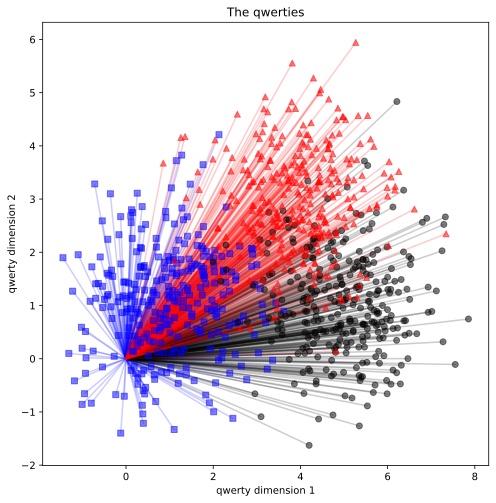

In [2]:
# create data

nPerClust = 300
blur = 1

A = [ 1, 1 ]
B = [ 5, 1 ]
C = [ 4, 3 ]

# generate data
a = [ A[0] + np.random.randn(nPerClust)*blur, A[1] + np.random.randn(nPerClust)*blur]
b = [ B[0] + np.random.randn(nPerClust)*blur, B[1] + np.random.randn(nPerClust)*blur]
c = [ C[0] + np.random.randn(nPerClust)*blur, C[1] + np.random.randn(nPerClust)*blur]


# true labels
labels_np = np.hstack((np.zeros((nPerClust)), np.ones((nPerClust)), 1 + np.ones((nPerClust))))

# concatenate into a matrix
data_np = np.hstack((a, b, c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long()

# show the data
fig = plt.figure(figsize = (8, 8))
# draw distance to origin
color = "bkr"
for i in range(len(data)):
    plt.plot([0, data[i, 0]], [0, data[i, 1]], color = color[labels[i]], alpha = .2)
plt.plot(data[np.where(labels == 0)[0], 0], data[np.where(labels == 0)[0], 1], "bs", alpha = .5)
plt.plot(data[np.where(labels == 1)[0], 0], data[np.where(labels == 1)[0], 1], "ko", alpha = .5)
plt.plot(data[np.where(labels == 2)[0], 0], data[np.where(labels == 2)[0], 1], "r^", alpha = .5)
plt.title("The qwerties")
plt.xlabel("qwerty dimension 1")
plt.ylabel("qwerty dimension 2")
plt.show()

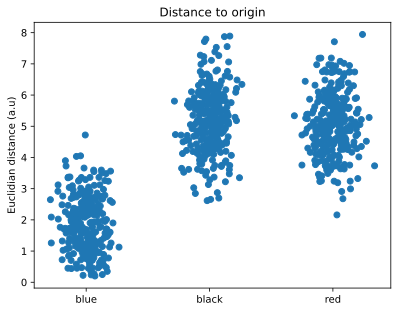

In [4]:
# compute Euclidean distance to the origin
dist2orig = torch.sqrt(data[:, 0]**2 + data[:, 1]**2)

plt.plot(labels+torch.randn(900)/10, dist2orig, "o")
plt.xticks([0, 1, 2], labels = ["blue", "black", "red"])
plt.ylabel("Euclidian distance (a.u)")
plt.title("Distance to origin")
plt.show()

In [6]:
# add that to the data matrix
dataAug = torch.cat((data, dist2orig.view(len(data), 1)), axis = 1) # converts dist2orig into a column vector

# check data sizes
print(data.shape)
print(dataAug.shape)
print(" ")

# look at some of the data
print(dataAug)

torch.Size([900, 2])
torch.Size([900, 3])
 
tensor([[0.6354, 0.3131, 0.7084],
        [0.4813, 0.4636, 0.6683],
        [1.3176, 2.6109, 2.9245],
        ...,
        [3.4973, 2.6385, 4.3810],
        [5.3502, 1.3761, 5.5243],
        [4.4180, 2.6658, 5.1600]])


In [7]:
train_data, test_data, train_labels, test_labels = train_test_split(dataAug, labels, test_size = 0.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# finally, translate into dataloader objects
batchsize = 16
train_loader = DataLoader(train_data, batch_size = batchsize, shuffle = True, drop_last = True)
test_loader = DataLoader(test_data, batch_size = test_data.tensors[0].shape[0])

In [13]:
# create a class for the model
def createTheQwertyNet(useExtraFeature = False):
    class qwertyNet(nn.Module):
        def __init__(self):
            super().__init__()

            # input layer
            if useExtraFeature:
                self.input = nn.Linear(3, 8)
            else:
                self.input = nn.Linear(2, 8)

            # hidden layer
            self.fc1 = nn.Linear(8, 8)

            # output layer
            self.output = nn.Linear(8, 3)

        # forward pass
        def forward(self, x):

            # print(x.shape) # comment out during training
            if not useExtraFeature:
                x = x[:, :2] # clip out extra feature and consider only first 2 columns
            # print(x.shape) # comment out during training
            
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            return self.output(x)

    # create the model instance
    net = qwertyNet()

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr = .001)

    return net, lossfun, optimizer

In [14]:
# test the model
print("Using augmented features")
net = createTheQwertyNet(True)[0]
net(next(iter(train_loader))[0])

print("\nNot Using augmented features")
net = createTheQwertyNet(False)[0]
net(next(iter(train_loader))[0]);

Using augmented features

Not Using augmented features


In [15]:
 # train the model

def trainTheModel(useExtraFeature = False):

    # number of epochs
    numepochs = 200
    
    # create a new model
    net, lossfun, optimizer = createTheQwertyNet(useExtraFeature)
    
    trainAcc = []
    testAcc = []
    losses = torch.zeros(numepochs)
    
    # train the model
    for epochi in range(numepochs):
        
        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)
            
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # loss from this batch
            batchLoss.append(loss.item())

            # compute training accuracy for this batch
            matches = torch.argmax(yHat, axis = 1) == y # booleans (false/true); selects the class with the highest predicted probability for each input.
            # The == operator compares the predicted class to the actual class, returning a Boolean tensor (True for correct predictions, False for incorrect).
            matchesNumeric = matches.float() # convert to numbers (0/1)
            accuracyPct = 100*torch.mean(matchesNumeric) # avg and * by 100
            batchAcc.append(accuracyPct)
            
        # now that we've trained through the batches, get avg training accuracy
        trainAcc.append(np.mean(batchAcc))

        # get avg losses over the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        X, y = next(iter(test_loader))  # extract X, y from test dataloader
        with torch.no_grad(): # deactivates auto grad
            yHat = net(X)

        # compute test accuracy
        testAcc.append(100 * torch.mean((torch.argmax(yHat, axis = 1) == y).float()))
        
    # function output
    return trainAcc, testAcc, losses, net

In [16]:
def plotTheResults():

  # compute accuracy over entire dataset (train+test)
  yHat = net(dataAug)
  predictions = torch.argmax(yHat,axis=1)
  accuracy = (predictions == labels).float()

  # and accuracy by group
  accuracyByGroup = np.zeros(3)
  for i in range(3):
    accuracyByGroup[i] = 100*torch.mean(accuracy[labels==i])


  # create the figure
  fig,ax = plt.subplots(2,2,figsize=(10,6))

  # plot the loss function
  ax[0,0].plot(losses.detach())
  ax[0,0].set_ylabel('Loss')
  ax[0,0].set_xlabel('epoch')
  ax[0,0].set_title('Losses')

  # plot the accuracy functions
  ax[0,1].plot(trainAcc,label='Train')
  ax[0,1].plot(testAcc,label='Test')
  ax[0,1].set_ylabel('Accuracy (%)')
  ax[0,1].set_xlabel('Epoch')
  ax[0,1].set_title('Accuracy')
  ax[0,1].legend()

  # plot overall accuracy by group
  ax[1,0].bar(range(3),accuracyByGroup)
  ax[1,0].set_ylim([np.min(accuracyByGroup)-5,np.max(accuracyByGroup)+5])
  ax[1,0].set_xticks([0,1,2])
  ax[1,0].set_xlabel('Group')
  ax[1,0].set_ylabel('Accuracy (%)')
  ax[1,0].set_title('Accuracy by group')

  # scatterplot of correct and incorrect labeled data
  colorShapes = [ 'bs','ko','g^' ] # data markers
  for i in range(3):
    # plot all data points
    ax[1,1].plot(dataAug[labels==i,0],dataAug[labels==i,1],colorShapes[i],
                 alpha=.3,label=f'Group {i}')
    
    # cross-out the incorrect ones
    idxErr = (accuracy==0) & (labels==i)
    ax[1,1].plot(dataAug[idxErr,0],dataAug[idxErr,1],'rx')

  ax[1,1].set_title('All groups')
  ax[1,1].set_xlabel('qwerty dimension 1')
  ax[1,1].set_ylabel('qwerty dimension 2')
  ax[1,1].legend()
  
  plt.tight_layout()
  plt.show()

Final Accuracy: 84.44%


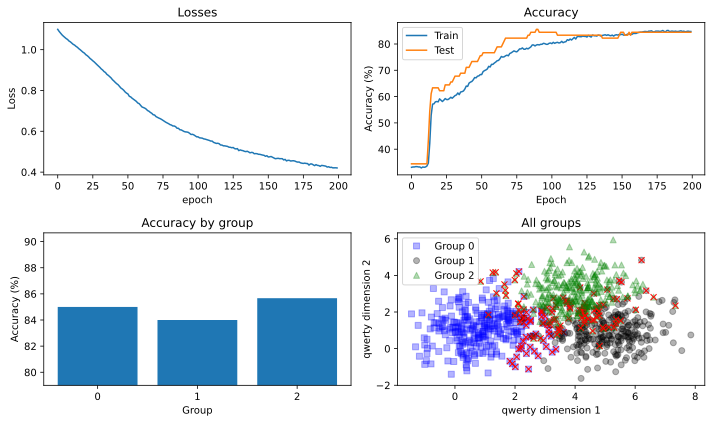

In [17]:
# run the model and visualize the results
trainAcc, testAcc, losses, net = trainTheModel(False)
print("Final Accuracy: %.2f%%" %testAcc[-1].item())
plotTheResults()

Final Accuracy: 86.67%


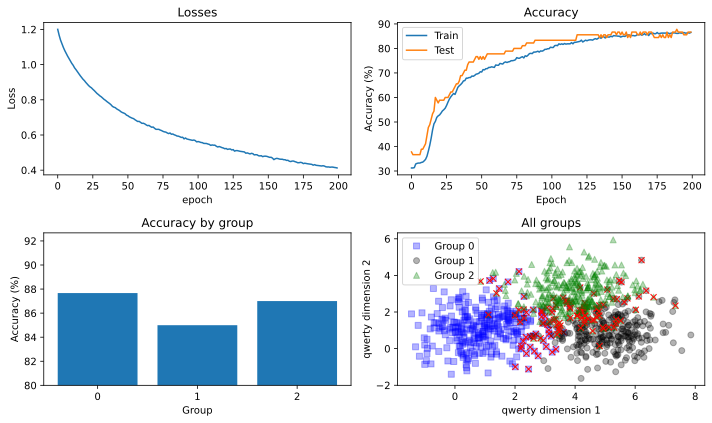

In [18]:
# run the model and visualize the results
trainAcc, testAcc, losses, net = trainTheModel(True)
print("Final Accuracy: %.2f%%" %testAcc[-1].item())
plotTheResults()

In [19]:
# run the experiment multiple times and do a t-test

finalacc2 = np.zeros(10)
finalacc3 = np.zeros(10)

for i in range(10):
    finalacc2[i] = trainTheModel(False)[1][-1] # get final element inside testAcc
    finalacc3[i] = trainTheModel(True)[1][-1] # get final element inside testAcc

# show the numbers
print(np.round(np.vstack((finalacc2, finalacc3)).T, 2))

# run the t-test and print the results
from scipy import stats
t, p = stats.ttest_ind(finalacc3, finalacc2)
print("\n\nt = %.2f, p = %.2f" %(t, p))

[[87.78 84.44]
 [84.44 72.22]
 [86.67 84.44]
 [86.67 87.78]
 [87.78 88.89]
 [83.33 85.56]
 [86.67 86.67]
 [84.44 85.56]
 [84.44 86.67]
 [85.56 85.56]]


t = -0.65, p = 0.53


In [20]:
# If p < 0.05: Statistically significant → There's likely a real difference between the two model configurations.
# If p ≥ 0.05: Not statistically significant → You can't confidently say one model performs better than the other.

In [22]:
# since p > 0.5 You can't confidently say one model performs better than the other.
# therefore, in this case using the simpler model instead of the augmented feature model is preferrable